## Creating Charts

The Google Earth Engine Python API does not come with a charting module. But you can use third-party modules to create interactive charts. You may also convert the Earth Engine objects to a Pandas dataframe and plot it using Python libraries like Matplotlib

This notebook shows how to use the `geemap` package to create a Time-Series Chart from a ImageCollection.

References:
* geemap [Chart module](https://geemap.org/chart/)
* geemap [Example notebook](https://geemap.org/notebooks/63_charts/)


In [1]:
import ee

In [ ]:
ee.Authenticate()

In [3]:
ee.Initialize()

Load the TerraClimate collection and select the 'tmmx' band.

In [51]:
terraclimate = ee.ImageCollection("IDAHO_EPSCOR/TERRACLIMATE")
tmax = terraclimate.select('tmmx')

Define a point location for the chart.

In [52]:
geometry = ee.Geometry.Point([77.57738128916243, 12.964758918835752])

Scale the band values so they are in Degree Celcius.

In [53]:
def scale_image(image):
  return ee.Image(image).multiply(0.1)\
    .copyProperties(image, ['system:time_start'])

tmaxScaled = tmax.map(scale_image)

Filter the collection.

In [54]:
filtered = tmaxScaled.filter(ee.Filter.date('1970-01-01', '2020-01-01')) \
                     .filter(ee.Filter.intersects('.geo', geometry))

To chart an image series in Python, we must first extract the values from each image and create a FeatureCollection.

In [55]:
def extract_data(image):
    stats = image.reduceRegion(**{ 
        'reducer':ee.Reducer.mean(),
        'geometry':geometry,
        'scale':5000
    })
    properties = {
        'month': image.get('system:index'),
        'tmmx': stats.get('tmmx')
    }
    return ee.Feature(None, properties)

data = ee.FeatureCollection(filtered.map(extract_data))

In [56]:
print(data.first().getInfo())

{'type': 'Feature', 'geometry': None, 'id': '197001', 'properties': {'month': '197001', 'tmmx': 27.8}}


## Create an Interactive Chart using geemap

In [57]:
from geemap import chart

In [96]:
options = {
    'title': 'Max Monthly Temperature at Bangalore', 
    'legend_location': 'top-right',
    'height': '500px',
    'ylabel': 'Temperature (C)'
}

In [97]:
chart.feature_byFeature(data, 'month', ['tmmx'], **options)

## Create a chart using Matplotlib

We can convert a FeatureCollection to a DataFrame using `geemap` helper function `ee_to_pandas`.

In [88]:
import geemap
df = geemap.ee_to_pandas(data)

In [89]:
%matplotlib inline
import matplotlib.pyplot as plt

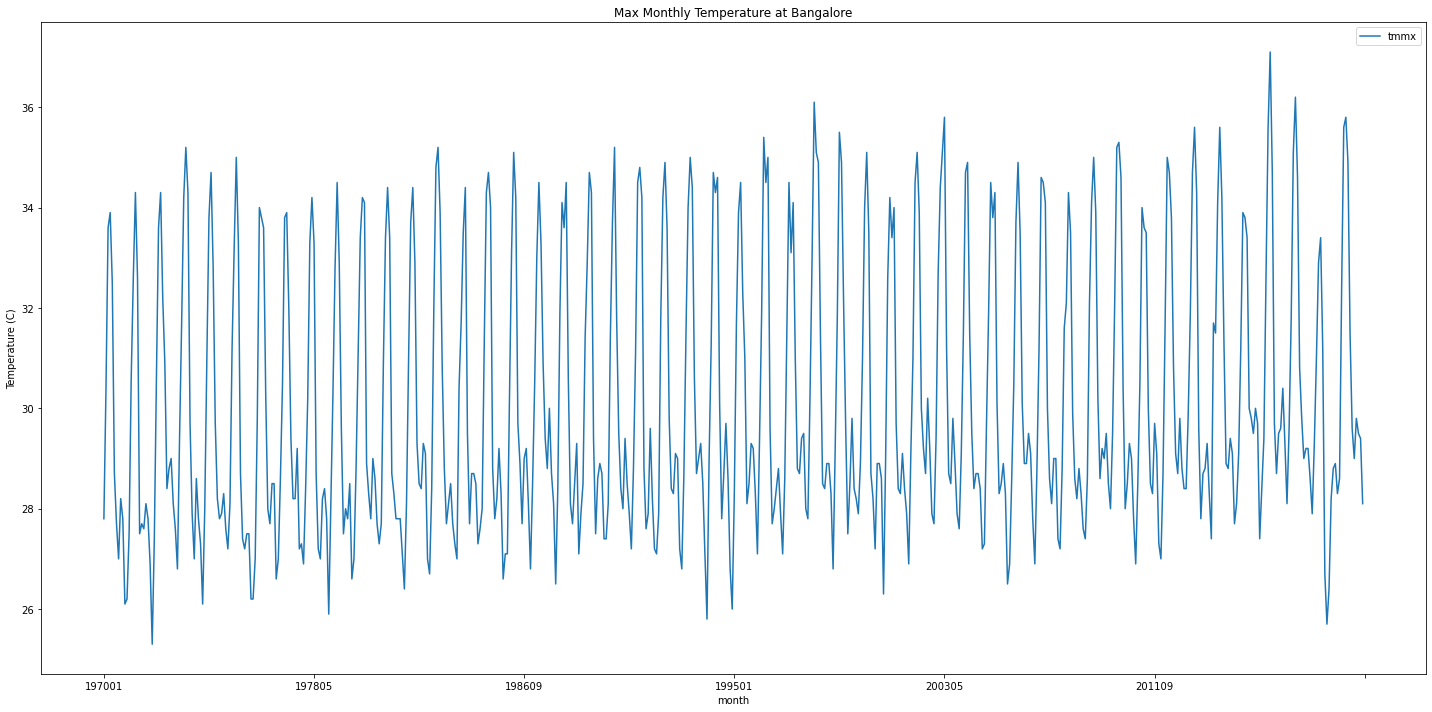

In [94]:
fig, ax = plt.subplots()
fig.set_size_inches(20,10)


df.plot(ax=ax,
        title='Max Monthly Temperature at Bangalore',
        x='month',
        ylabel='Temperature (C)')
plt.tight_layout()
plt.show()